In [1]:
import torch
import faces_model
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
from net_sphere import sphere20a
from open_face_model import OpenFace
import matplotlib.pyplot as plt

import torchvision

import torch.nn as nn

from datasets import celebA
from data_utils import *

In [2]:
class ZeroPadBottom(object):
    ''' Zero pads batch of image tensor Variables on bottom to given size. Input (B, C, H, W) - padded on H axis. '''
    def __init__(self, size, use_gpu=True):
        self.size = size
        self.use_gpu = use_gpu
        
    def __call__(self, sample):
        B, C, H, W = sample.size()
        diff = self.size - H
        padding = Variable(torch.zeros(B, C, diff, W), requires_grad=False)
        if self.use_gpu:
            padding = padding.cuda()
        zero_padded = torch.cat((sample, padding), dim=2)
        return zero_padded

In [7]:
model = torch.load('final_models/emoji/fin_model_emoji.tar')

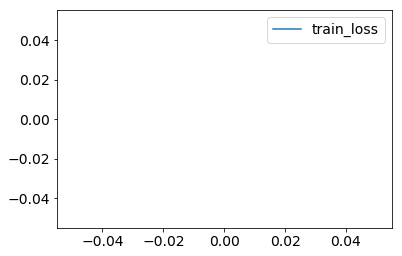

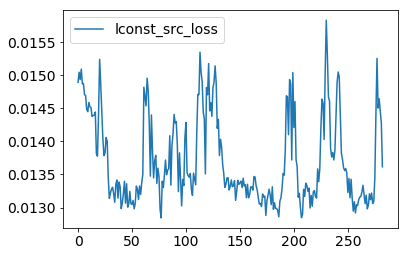

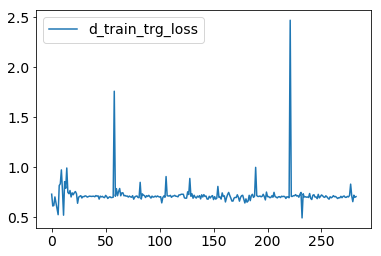

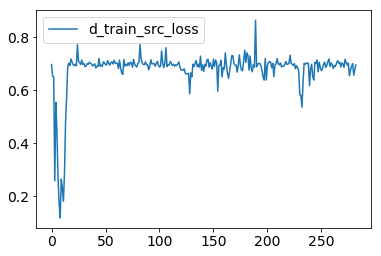

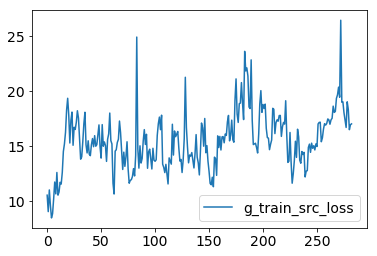

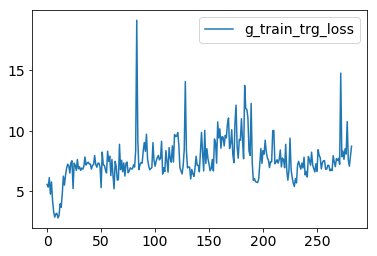

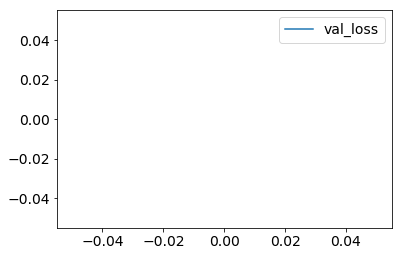

In [157]:
import matplotlib
plt.figure()
matplotlib.rcParams['font.size'] = 14
for key in model:
    if 'loss' in key and model[key] is not None:
        y = model[key][2:]
        x = np.arange(0, 11450, 50)
        plt.plot(y,label=key)
        plt.legend()
#         plt.ylabel('Loss')
#         plt.xlabel('Batches (size 128)')
        plt.show()

In [3]:
from predict_all import *

/root/anaconda2/envs/cs7643/lib/python2.7/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'faces_model.G' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
img = Image.open('./predictset/emoji/000001.jpg')

In [5]:
image = predict_emoji(img) 

predict emoji
(torch.Size([1, 128]), torch.Size([1, 736]))


/root/anaconda2/envs/cs7643/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/root/anaconda2/envs/cs7643/lib/python2.7/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


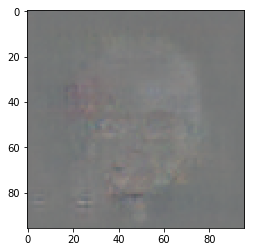

In [6]:
plt.imshow(image)

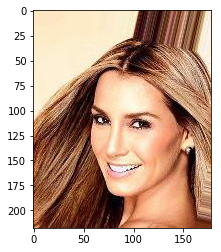

In [14]:
plt.imshow(img)